<a href="https://colab.research.google.com/github/alberto93927/ML_Report/blob/main/Vehicle_Accident_Severity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Severity of Vehicle Accidents in Montgomery County, Maryland

#### Alberto Garcia, Erica Lopez-Hernandez, CST 383

### Introduction
This notebook focuses on analyzing the Montgomery County crash reporting dataset to uncover patterns, trends, and insights that can help us better understand traffic incidents. The goal is to preprocess the data, visualize important trends, and use machine learning models to answer key questions about injury severity, and contributing factors.

The dataset contains detailed records of traffic incidents, including information about crash data from 2015 to 2024, locations, weather conditions, involved vehicles, and injury severities. With a total of 39 columns and over 188,000 entries, this dataset provides an abundant source of information for answering the following questions:

What factors contribute most to injury severity?
Are there patterns related to time in crash occurrences?
How do weather and road conditions impact injury severity?

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import tree
import graphviz
from IPython.display import display, HTML
from sklearn.utils import resample

In [ ]:
sns.set_theme(context='notebook', style='whitegrid')
plt.rcParams['figure.figsize'] = 6,4
display(HTML("<style>.container { width:90% !important; }</style>"))

### Read the data

The following data was downloaded on December 3rd, 2024.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/alexknite/cst383-project2/refs/heads/main/03122024_Crash_Reporting_Data.csv')

<ipython-input-3-45a6195c95c9>:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('https://raw.githubusercontent.com/alexknite/cst383-project2/refs/heads/main/03122024_Crash_Reporting_Data.csv')


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188800 entries, 0 to 188799
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Report Number                  188800 non-null  object 
 1   Local Case Number              188800 non-null  object 
 2   Agency Name                    188800 non-null  object 
 3   ACRS Report Type               188800 non-null  object 
 4   Crash Date/Time                188800 non-null  object 
 5   Route Type                     170344 non-null  object 
 6   Road Name                      169299 non-null  object 
 7   Cross-Street Name              162424 non-null  object 
 8   Off-Road Description           17418 non-null   object 
 9   Municipality                   19126 non-null   object 
 10  Related Non-Motorist           6065 non-null    object 
 11  Collision Type                 188215 non-null  object 
 12  Weather                       

In [ ]:
df.sample(5, random_state=0)

,Report Number,Local Case Number,Agency Name,ACRS Report Type,Crash Date/Time,Route Type,Road Name,Cross-Street Name,Off-Road Description,Municipality,...,Vehicle Going Dir,Speed Limit,Driverless Vehicle,Parked Vehicle,Vehicle Year,Vehicle Make,Vehicle Model,Latitude,Longitude,Location
31247,MCP26880030,180061041,Montgomery County Police,Injury Crash,12/06/2018 04:08:00 PM,Maryland (State),MONTGOMERY VILLAGE AVE,FREDERICK RD,NaN,NaN,...,East,35,No,No,2004,HONDA,ODYSSEY,39.153815,-77.210802,"(39.153815, -77.21080167)"
33439,MCP05390019,15003680,Montgomery County Police,Property Damage Crash,01/23/2015 08:19:00 AM,Maryland (State),CONNECTICUT AVE,GEORGIA AVE,NaN,NaN,...,North,45,No,No,2006,NEW FLYER,TBU,39.083175,-77.078793,"(39.083175, -77.07879333)"
154379,MCP3190002V,210041118,Montgomery County Police,Injury Crash,10/14/2021 08:34:00 AM,County,ASPEN HILL RD,GLASGOW DR,NaN,NaN,...,North,35,No,No,2008,JEEP,4X4,39.073248,-77.095807,"(39.07324833, -77.09580667)"
125583,MCP11130010,16040717,Montgomery County Police,Injury Crash,08/11/2016 02:11:00 PM,County,PIEDMONT RD,SKYLARK RD,NaN,NaN,...,West,35,No,No,2005,GMC,SIERRA,39.244305,-77.259823,"(39.244305, -77.25982333)"
117877,MCP25980016,17005124,Montgomery County Police,Property Damage Crash,01/29/2017 08:38:00 PM,Maryland (State),GEORGIA AVE,FOREST GLEN RD,NaN,NaN,...,North,35,No,No,2012,TOYOTA,CAMRY,39.015643,-77.042573,"(39.01564333, -77.04257333)"


### Data Preprocessing

For the preprocessing, the following columns were chosen to be dropped for a variety of reasons. A lot of these variables are identifiers, like Person ID, Vehicle ID, Report Number, and Local Case Number. For our analysis, those variables aren't relevant. Other variables, like location, were dropped because they provide redundant data given other variables in the dataset, like latitude and longitude.

In [ ]:
columns_to_drop = [
    'Report Number',
    'Local Case Number',
    'Location',
    'Cross-Street Name',
    'Off-Road Description',
    'Municipality',
    'Non-Motorist Substance Abuse',
    'Related Non-Motorist',
    'Drivers License State',
    'Person ID',
     'Vehicle Year',
    'Driver Distracted By'
]
df.drop(columns=columns_to_drop, axis=1, inplace=True)

When taking a look at our predictor variables, we notice that there isn't a standard for naming conditions in the column. Therefore, we will standardize them for more cohesive data visualizations.


In [ ]:
df['Injury Severity'].value_counts(dropna=False)

,count
Injury Severity,
NO APPARENT INJURY,141197
POSSIBLE INJURY,17481
No Apparent Injury,12918
SUSPECTED MINOR INJURY,11871
Suspected Minor Injury,1470
SUSPECTED SERIOUS INJURY,1414
Possible Injury,1107
NaN,1030
FATAL INJURY,154


In [ ]:
df['Weather'].value_counts(dropna=False)

,count
Weather,
CLEAR,116781
RAINING,20609
CLOUDY,17295
NaN,13356
Clear,13087
Rain,1858
SNOW,1444
Cloudy,1422
UNKNOWN,693


In [ ]:
df['Surface Condition'].value_counts(dropna=False)

,count
Surface Condition,
DRY,120577
WET,28429
NaN,21668
Dry,12563
Wet,2346
ICE,1058
SNOW,938
UNKNOWN,509
SLUSH,204


In [ ]:
df['Vehicle Body Type'].value_counts(dropna=False)

,count
Vehicle Body Type,
PASSENGER CAR,119110
(SPORT) UTILITY VEHICLE,15990
Passenger Car,10690
PICKUP TRUCK,6787
VAN,4958
TRANSIT BUS,3642
SCHOOL BUS,2975
NaN,2824
Sport Utility Vehicle,2693


In [ ]:
df['Light'].value_counts(dropna=False)

,count
Light,
DAYLIGHT,116150
DARK LIGHTS ON,39551
Daylight,11733
DARK NO LIGHTS,4967
DUSK,3935
Dark - Lighted,3700
DAWN,3472
DARK -- UNKNOWN LIGHTING,1578
NaN,1445


In [ ]:
df['Speed Limit'].value_counts(dropna=False)

,count
Speed Limit,
35,56179
40,35854
25,26551
30,25940
45,13217
15,6413
0,6227
50,5026
55,4325


In [ ]:
df['Driver Substance Abuse'].value_counts(dropna=False)

,count
Driver Substance Abuse,
NONE DETECTED,122545
NaN,31320
"Not Suspect of Alcohol Use, Not Suspect of Drug Use",14358
UNKNOWN,11990
ALCOHOL PRESENT,4087
"Unknown, Unknown",1737
ALCOHOL CONTRIBUTED,1435
"Suspect of Alcohol Use, Not Suspect of Drug Use",423
ILLEGAL DRUG PRESENT,259


In [ ]:
df['Traffic Control'].value_counts(dropna=False)

,count
Traffic Control,
NO CONTROLS,68626
TRAFFIC SIGNAL,58898
NaN,26909
STOP SIGN,12488
No Controls,7878
Traffic Control Signal,5394
FLASHING TRAFFIC SIGNAL,2132
OTHER,1991
YIELD SIGN,1727


In [ ]:
df['Vehicle Make'].value_counts(dropna=False)

,count
Vehicle Make,
TOYOTA,26325
HONDA,21285
FORD,18697
NISSAN,9519
TOYT,8841
...,...
MAZFA,1
SATRUN,1
5NPEC4AB5EH926862,1


In [ ]:
df['Collision Type'].value_counts(dropna=False)

,count
Collision Type,
SAME DIR REAR END,55759
STRAIGHT MOVEMENT ANGLE,30342
OTHER,19030
SAME DIRECTION SIDESWIPE,16227
SINGLE VEHICLE,15873
HEAD ON LEFT TURN,12926
Front to Rear,5027
SAME DIRECTION RIGHT TURN,3832
HEAD ON,3786


Splitting them into categories will help us better identify trends.

In [ ]:
df['Speed Limit'] = df['Speed Limit'].replace(0, None)

def categorize_speed_limit(speed):
    if speed is None:
        return 'UNKNOWN'
    elif speed <= 15:
        return 'Very Low Speed'
    elif speed <= 35:
        return 'Low Speed'
    elif speed <= 55:
        return 'Medium Speed'
    else:
        return 'High Speed'

df['Speed Limit Category'] = df['Speed Limit'].apply(categorize_speed_limit)
df['Speed Limit Category'].value_counts()

,count
Speed Limit Category,
Low Speed,110071
Medium Speed,58422
Very Low Speed,13925
UNKNOWN,6227
High Speed,155


In [ ]:
df['Weather'] = df['Weather'].str.upper()
df['Weather'] = df['Weather'].fillna('UNKNOWN')

weather_mapping = {
    'RAIN': 'RAINING',
    'RAINING': 'RAINING',
    'SNOW': 'SNOW',
    'BLOWING SNOW': 'SNOW',
    'CLOUDY': 'CLOUDY',
    'FOGGY': 'OTHER',
    'FOG, SMOG, SMOKE': 'OTHER',
    'FREEZING RAIN OR FREEZING DRIZZLE': 'OTHER',
    'WINTRY MIX': 'SNOW',
    'BLOWING SAND, SOIL, DIRT': 'OTHER',
    'SEVERE CROSSWINDS': 'OTHER',
    'SLEET OR HAIL': 'OTHER',
    'SLEET': 'OTHER',
    'CLEAR':'CLEAR',
    'UNKNOWN':'UNKNOWN',
    'OTHER':'OTHER',
    'SEVERE WINDS':'OTHER',
    'FREEZING RAIN':'OTHER',
    'BLOWING SAND, SOIL, DIRT, SANDSTORM':'OTHER',
    'FOG':'OTHER'

}

df['Weather'] = df['Weather'].replace(weather_mapping)
df['Weather'].value_counts()

,count
Weather,
CLEAR,129868
RAINING,22467
CLOUDY,18717
UNKNOWN,14158
SNOW,2108
OTHER,1482


In [ ]:
df['Collision Type'] = df['Collision Type'].str.upper()
df['Collision Type'] = df['Collision Type'].fillna('UNKNOWN')

collision_mapping = {

    'SAME DIR REAR END': 'REAR END',
    'FRONT TO REAR': 'REAR END',
    'REAR TO FRONT': 'REAR END',
    'REAR TO SIDE': 'REAR END',
    'SAME DIR REND LEFT TURN': 'REAR END',
    'SAME DIR REND RIGHT TURN': 'REAR END',

    'STRAIGHT MOVEMENT ANGLE': 'ANGLE',
    'ANGLE': 'ANGLE',
    'ANGLE MEETS LEFT TURN': 'ANGLE',
    'ANGLE MEETS RIGHT TURN': 'ANGLE',
    'ANGLE MEETS LEFT HEAD ON': 'ANGLE',

    'SAME DIRECTION SIDESWIPE': 'SIDESWIPE',
    'OPPOSITE DIRECTION SIDESWIPE': 'SIDESWIPE',
    'SIDESWIPE, SAME DIRECTION': 'SIDESWIPE',
    'SIDESWIPE, OPPOSITE DIRECTION': 'SIDESWIPE',

    'HEAD ON': 'HEAD ON',
    'HEAD ON LEFT TURN': 'HEAD ON',
    'FRONT TO FRONT': 'HEAD ON',


    'SINGLE VEHICLE': 'SINGLE VEHICLE',
    'SINGLE VEHICLE ': 'SINGLE VEHICLE',

    'SAME DIR BOTH LEFT TURN': 'ANGLE',
    'OPPOSITE DIR BOTH LEFT TURN': 'ANGLE',

    'OTHER': 'OTHER',
    'UNKNOWN': 'OTHER',
    'UNKNOW': 'OTHER',
    'OTHER ': 'OTHER',
    'UNKNWON': 'OTHER',
    'REAR TO REAR': 'OTHER',

}

df['Collision Type'] = df['Collision Type'].replace(collision_mapping)

df['Collision Type'].value_counts()


,count
Collision Type,
REAR END,63150
ANGLE,38435
SIDESWIPE,22399
OTHER,21805
SINGLE VEHICLE,17790
HEAD ON,17674
SAME DIRECTION RIGHT TURN,3832
SAME DIRECTION LEFT TURN,3715


In [ ]:
df['Driver Substance Abuse'] = df['Driver Substance Abuse'].str.upper()
df['Driver Substance Abuse'] = df['Driver Substance Abuse'].fillna('UNKNOWN')

substance_mapping = {
    'NONE DETECTED': 'NONE',
    'NOT SUSPECT OF ALCOHOL USE, NOT SUSPECT OF DRUG USE': 'NONE',
    'ALCOHOL PRESENT': 'ALCOHOL',
    'ALCOHOL CONTRIBUTED': 'ALCOHOL',
    'SUSPECT OF ALCOHOL USE, NOT SUSPECT OF DRUG USE': 'ALCOHOL',
    'SUSPECT OF ALCOHOL USE, UNKNOWN': 'ALCOHOL',
    'SUSPECT OF ALCOHOL USE, SUSPECT OF DRUG USE': 'COMBINATION',
    'ILLEGAL DRUG PRESENT': 'DRUG',
    'ILLEGAL DRUG CONTRIBUTED': 'DRUG',
    'NOT SUSPECT OF ALCOHOL USE, SUSPECT OF DRUG USE': 'DRUG',
    'UNKNOWN, SUSPECT OF DRUG USE': 'DRUG',
    'MEDICATION PRESENT': 'MEDICATION',
    'MEDICATION CONTRIBUTED': 'MEDICATION',
    'COMBINED SUBSTANCE PRESENT': 'COMBINATION',
    'COMBINATION CONTRIBUTED': 'COMBINATION',
    'OTHER': 'OTHER',

    'UNKNOWN': 'UNKNOWN',
    'UNKNOWN, UNKNOWN': 'UNKNOWN',
    'UNKNOWN, NOT SUSPECT OF DRUG USE': 'UNKNOWN',
    'NOT SUSPECT OF ALCOHOL USE, UNKNOWN': 'UNKNOWN'
}

df['Driver Substance Abuse'] = df['Driver Substance Abuse'].replace(substance_mapping)

df['Driver Substance Abuse'].value_counts()


,count
Driver Substance Abuse,
NONE,136903
UNKNOWN,45109
ALCOHOL,5997
DRUG,383
MEDICATION,181
COMBINATION,168
OTHER,59


In [ ]:
df['Surface Condition'] = df['Surface Condition'].str.upper()
df['Surface Condition'] = df['Surface Condition'].fillna('UNKNOWN')

surface_mapping = {
    'DRY': 'DRY',
    'WET': 'WET',
    'ICE': 'ICE',
    'ICE/FROST': 'ICE',
    'SNOW': 'SNOW',
    'SLUSH': 'SNOW',
    'MUD, DIRT, GRAVEL': 'OTHER',
    'MUD, DIRT, GRAVEL': 'OTHER',
    'SAND': 'OTHER',
    'WATER(STANDING/MOVING)': 'OTHER',
    'WATER (STANDING, MOVING)': 'OTHER',
    'OIL': 'OTHER',
    'UNKNOWN': 'UNKNOWN',
    'OTHER': 'OTHER',
    'MUD/DIRT/GRAVEL': 'OTHER',
    'WATER':'OTHER'
}

df['Surface Condition'] = df['Surface Condition'].replace(surface_mapping)
df['Surface Condition'].value_counts()

,count
Surface Condition,
DRY,133140
WET,30775
UNKNOWN,22177
SNOW,1256
ICE,1125
OTHER,327


In [ ]:
df['Vehicle Body Type'] = df['Vehicle Body Type'].str.upper()
df['Vehicle Body Type'] = df['Vehicle Body Type'].fillna('UNKNOWN')

vehicle_mapping = {

    'PASSENGER CAR': 'PASSENGER CAR',
    'PASSENGER VEHICLE': 'PASSENGER CAR',
    'STATION WAGON': 'PASSENGER CAR',

    '(SPORT) UTILITY VEHICLE': 'SUV',
    'SPORT UTILITY VEHICLE': 'SUV',

    'PICKUP TRUCK': 'PICKUP TRUCK',
    'PICKUP': 'PICKUP TRUCK',

    'VAN': 'VAN',
    'CARGO VAN/LIGHT TRUCK 2 AXLES (OVER 10,000LBS (4,536 KG))': 'VAN',
    'VAN - PASSENGER (&LT;9 SEATS)': 'VAN',
    'VAN - PASSENGER (15 SEATS)': 'VAN',
    'VAN - PASSENGER (9 OR 12 SEATS)': 'VAN',
    'VAN - CARGO': 'VAN',

    'TRANSIT BUS': 'BUS',
    'SCHOOL BUS': 'BUS',
    'CROSS COUNTRY BUS': 'BUS',
    'BUS - SCHOOL': 'BUS',
    'BUS - TRANSIT': 'BUS',
    'BUS - MINI': 'BUS',
    'OTHER BUS': 'BUS',
    'BUS - CROSS COUNTRY': 'BUS',
    'BUS - OTHER TYPE': 'BUS',

    'POLICE VEHICLE/NON EMERGENCY': 'EMERGENCY VEHICLE',
    'POLICE VEHICLE/EMERGENCY': 'EMERGENCY VEHICLE',
    'AMBULANCE/EMERGENCY': 'EMERGENCY VEHICLE',
    'FIRE VEHICLE/EMERGENCY': 'EMERGENCY VEHICLE',
    'FIRE VEHICLE/NON EMERGENCY': 'EMERGENCY VEHICLE',
    'AMBULANCE/NON EMERGENCY': 'EMERGENCY VEHICLE',

    'MEDIUM/HEAVY TRUCKS 3 AXLES (OVER 10,000LBS (4,536KG))': 'COMMERCIAL TRUCK',
    'OTHER LIGHT TRUCKS (10,000LBS (4,536KG) OR LESS)': 'COMMERCIAL TRUCK',
    'OTHER TRUCKS': 'COMMERCIAL TRUCK',
    'TRUCK TRACTOR': 'COMMERCIAL TRUCK',
    'SINGLE-UNIT TRUCK': 'COMMERCIAL TRUCK',

    'MOTORCYCLE': 'MOTORCYCLE',
    'MOTORCYCLE - 2 WHEELED': 'MOTORCYCLE',
    'MOTORCYCLE - 3 WHEELED': 'MOTORCYCLE',
    'ALL TERRAIN VEHICLE (ATV)': 'MOTORCYCLE',
    'ALL-TERRAIN VEHICLE/ALL-TERRAIN CYCLE (ATV/ATC)': 'MOTORCYCLE',
    'RECREATIONAL OFF-HIGHWAY VEHICLES (ROV)': 'MOTORCYCLE',
    'AUTOCYCLE': 'MOTORCYCLE',
    'MOPED OR MOTORIZED BICYCLE': 'MOTORCYCLE',
    'MOPED': 'MOTORCYCLE',


    'SNOWMOBILE': 'OTHER',
    'FARM VEHICLE': 'OTHER',
    'FARM EQUIPMENT': 'OTHER',
    'FARM EQUIPMENT (TRACTOR, COMBINE HARVESTER, ETC.)': 'OTHER',
    'CONSTRUCTION EQUIPMENT (BACKHOE, BULLDOZER, ETC.)': 'OTHER',
    'LOW SPEED VEHICLE': 'OTHER',
    'RECREATIONAL VEHICLE': 'OTHER',
    'LIMOUSINE': 'OTHER',


    'UNKNOWN': 'UNKNOWN',
    'OTHER': 'OTHER'
}

df['Vehicle Body Type'] = df['Vehicle Body Type'].replace(vehicle_mapping)
df['Vehicle Body Type'].value_counts()


,count
Vehicle Body Type,
PASSENGER CAR,130606
SUV,18683
BUS,7909
PICKUP TRUCK,7655
VAN,7303
EMERGENCY VEHICLE,5000
COMMERCIAL TRUCK,4277
UNKNOWN,3966
OTHER,2107


In [ ]:
df['Light'] = df['Light'].str.upper()

light_mapping = {
    'DAYLIGHT': 'DAYLIGHT',
    'DARK LIGHTS ON' : 'DARK',
    'DARK NO LIGHTS': 'DARK',
    'DARK - LIGHTED' : 'DARK',
    'DAWN': 'DARK',
    'DUSK': 'DARK',
    'DARK -- UNKNOWN LIGHTING' : 'DARK',
    'DARK - UNKNOWN LIGHTING' : 'DARK',
    'DARK - UNKNOWN': 'DARK',
    'DARK - NOT LIGHTED': 'DARK',
    'UNKNOWN': 'UNKNOWN',
    'OTHER' : 'UNKNOWN'

}

df['Light'] = df['Light'].replace(light_mapping)
df['Light'].value_counts()

,count
Light,
DAYLIGHT,127883
DARK,58331
UNKNOWN,1141


In [ ]:
df['Vehicle Movement'] = df['Vehicle Movement'].str.upper()
vehicle_movement_mapping = {'MAKING U-TURN' : 'MAKING U-TURN',
                            'MAKING U TURN' : 'MAKING U-TURN',
                            'TURNING LEFT' : 'TURNING LEFT',
                            'MAKING LEFT TURN' : 'TURNING LEFT',
                            'MAKING RIGHT TURN' : 'TURNING RIGHT',
                            'TURNING RIGHT': 'TURNING RIGHT',
                            'MOVING CONSTANT SPEED':'MOVING CONSTANT SPEED',
                            'SLOWING OR STOPPING':'STOPPED',
                            'STOPPED IN TRAFFIC LANE': 'STOPPED',
                            'ACCELERATING':'ACCELERATING',
                            'BACKING' : 'BACKING',
                            'CHANGING LANES':'CHANGING LANES',
                            'STARTING FROM LANE':'STARTING FROM LANE',
                            'PARKED':'PARKED',
                            'UNKNOWN':'UNKNOWN',
                            'PARKING':'PARKED',
                            'STARTING FROM PARKED':'PARKED',
                            'STOPPED IN TRAFFIC':'STOPPED',
                            'ENTERING TRAFFIC LANE':'CHANGING LANES',
                            'PASSING':'CHANGING LANES',
                            'OTHER':'OTHER',
                            'NEGOTIATING A CURVE':'OTHER',
                            'SKIDDING':'OTHER',
                            'LEAVING TRAFFIC LANE':'CHANGING LANES',
                            'RIGHT TURN ON RED':'OTHER',
                            'OVERTAKING/PASSING':'PASSING',
                            'DRIVERLESS MOVING VEH.':'OTHER',
                            'TURNING':'OTHER'}

df['Vehicle Movement'] = df['Vehicle Movement'].replace(vehicle_movement_mapping)
df['Vehicle Movement'].value_counts()

,count
Vehicle Movement,
MOVING CONSTANT SPEED,73732
STOPPED,46237
TURNING LEFT,18495
ACCELERATING,10766
CHANGING LANES,7709
PARKED,6876
BACKING,6436
TURNING RIGHT,6055
STARTING FROM LANE,4507


In [ ]:
df['Traffic Control'] = df['Traffic Control'].str.upper()
trafficControl_mapping = {    'NO CONTROLS': 'NO CONTROLS','TRAFFIC SIGNAL': 'CONTROLS','STOP SIGN': 'CONTROLS',
                              'FLASHING TRAFFIC SIGNAL': 'CONTROLS','OTHER': 'OTHER',
                              'YIELD SIGN': 'CONTROLS','PERSON': 'CONTROLS','FLASHING TRAFFIC CONTROL SIGNAL': 'CONTROLS',
                              'WARNING SIGN': 'CONTROLS','UNKNOWN': 'NO CONTROLS','PREDESTRIAN CROSSING SIGN': 'CONTROLS',
                              'OTHER PAVEMENT MARKING (EXCLUDING EDGELINES, CENTERLINES, OR LANE LINES)': 'CONTROLS',
                              'LANE USE CONTROL SIGNAL': 'CONTROLS',
                              'PEDESTRIAN CROSSING': 'CONTROLS','OTHER SIGNAL': 'CONTROLS','OTHER WARNING SIGN': 'CONTROLS',
                              'RAILWAY CROSSING DEVICE': 'CONTROLS','CURVE AHEAD WARNING SIGN': 'CONTROLS','SCHOOL ZONE SIGN DEVICE': 'CONTROLS',
                              'RAMP METER SIGNAL': 'CONTROLS','REDUCE SPEED AHEAD WARNING SIGN': 'CONTROLS','SCHOOL ZONE SIGN': 'CONTROLS',
                              'SCHOOL ZONE' : 'CONTROLS','PEDESTRIAN CROSSING SIGN' : 'CONTROLS', 'TRAFFIC CONTROL SIGNAL' : 'CONTROLS',
                              'PERSON (INCLUDING FLAGGER, LAW ENFORCEMENT, CROSSING GUARD, ETC.' : 'CONTROLS', 'BICYCLE CROSSING SIGN' : 'CONTROLS',
                              'FLASHING RAILROAD CROSSING SIGNAL (MAY INCLUDE GATES)' : 'CONTROLS',
                              'INTERSECTION AHEAD WARNING SIGN' : 'CONTROLS'}

df['Traffic Control'] = df['Traffic Control'].replace(trafficControl_mapping)
df['Traffic Control'].value_counts()

,count
Traffic Control,
CONTROLS,83032
NO CONTROLS,76789
OTHER,2070


In [ ]:
df['Vehicle Make'] = df['Vehicle Make'].str.upper()
make_mapping = {'TOYOTA' : 'TOYOTA', 'TOYT' : 'TOYOTA',
                'HONDA' : 'HONDA', 'HOND':'HONDA',
                'FORD':'FORD',
                'NISSAN':'NISSAN','NISS' : 'NISSAN','NISSASN':'NISSAN',
                'CHEVROLET': 'CHEVROLET','CHEV': 'CHEVROLET','CHEVY':'CHEVROLET', 'CHEVOLET':'CHEVROLET','CHEVORLET':'CHEVROLET',
                'VOLKSWAGON':'VOLSKWAGON', 'VOLKS':'VOLSKWAGON','VOLKSWAGEN':'VOLSKWAGON', 'VOLK':'VOLSKWAGON',
                'HYUNDAI' : 'HYUNDAI','HYUN':'HYUNDAI','HYUNDAY':'HYUNDAI',
                'JEEP':'JEEP',
                'DODGE':'DODGE','DODG': 'DODGE',
                'BMW':'BMW',
                'ACURA':'ACURA',
                'LEXUS':'LEXUS',
                'SUBARU':'SUBARU',
                'MAZDA':'MAZDA', 'MAZD':'MAZDA',
                'MERZ':'MERCEDES-BENZ', 'MERCEDES' : 'MERCEDES-BENZ', 'MERCEDES-BENS':'MERCEDES-BENZ', 'MERCEDES BENZ':'MERCEDES-BENS', 'MERCEDEES':'MERCEDES-BENS',
                'SUBA':'SUBARU', 'SUB':'SUBARU',
                'ACUR':'ACURA',
                'LECUS':'LEXUS', 'HONDDA':'HONDA','SUBAR':'SUBARU',
                'TOTT':'TOYOTA','TOYOTOA':'TOYOTA', 'CEHVY':'CHEVROLET', 'TOYITA':'TOYOTA', 'CHEVERLOET':'CHEVROLET',
                'HHONDA':'HONDA',}

df['Vehicle Make'] = df['Vehicle Make'].replace(make_mapping)
top_makes = list(make_mapping.values())
df_filtered = df[df['Vehicle Make'].isin(top_makes)]


In the Injury Severity column, FATAL INJURY is actually fairly rare.

In [ ]:
df['Injury Severity'] = df['Injury Severity'].str.upper()
df['Injury Severity'].value_counts(dropna=False)

,count
Injury Severity,
NO APPARENT INJURY,154115
POSSIBLE INJURY,18588
SUSPECTED MINOR INJURY,13341
SUSPECTED SERIOUS INJURY,1554
NaN,1030
FATAL INJURY,172


For the purpose of this analysis, we'll combine FATAL INJURY with SUSPECTED SERIOUS INJURY. We will also be undersampling the no injury value to better balance our data set.

In [ ]:
df['Injury Severity'] = df['Injury Severity'].str.upper()
injury_mapping = {'NO APPARENT INJURY' : 'NO INJURY',
                  'POSSIBLE INJURY' : 'NOT SEVERE',
                  'SUSPECTED MINOR INJURY' : 'NOT SEVERE',
                  'SUSPECTED SERIOUS INJURY' : 'SEVERE INJURY',
                  'FATAL INJURY' : 'SEVERE INJURY'}

df['Injury Severity'] = df['Injury Severity'].replace(injury_mapping)
df['Injury Severity'].value_counts(dropna=False)

,count
Injury Severity,
NO INJURY,154115
NOT SEVERE,31929
SEVERE INJURY,1726
NaN,1030


Before we continue we will see just how impactful each value is in the overall column by checking the cumulative sum. From here we will determine the values we wish to keep.

In [ ]:
df['Weather'].value_counts(normalize=True).cumsum()

,proportion
Weather,
CLEAR,0.687860
RAINING,0.806859
CLOUDY,0.905996
UNKNOWN,0.980985
SNOW,0.992150
OTHER,1.000000


In [ ]:
df['Vehicle Make'].value_counts(normalize = True).cumsum()[:20]

,proportion
Vehicle Make,
TOYOTA,0.186733
HONDA,0.330379
FORD,0.429653
NISSAN,0.494276
CHEVROLET,0.556213
HYUNDAI,0.591776
DODGE,0.622062
JEEP,0.644156
ACURA,0.666238


In [ ]:
df['Surface Condition'].value_counts(normalize=True).cumsum()

,proportion
Surface Condition,
DRY,0.705191
WET,0.868194
UNKNOWN,0.985657
SNOW,0.992309
ICE,0.998268
OTHER,1.000000


In [ ]:
df['Vehicle Body Type'].value_counts(normalize=True).cumsum()

,proportion
Vehicle Body Type,
PASSENGER CAR,0.691769
SUV,0.790726
BUS,0.832617
PICKUP TRUCK,0.873162
VAN,0.911843
EMERGENCY VEHICLE,0.938326
COMMERCIAL TRUCK,0.960980
UNKNOWN,0.981986
OTHER,0.993146


In [ ]:
df['Weather'].value_counts(normalize=True).cumsum()

,proportion
Weather,
CLEAR,0.687860
RAINING,0.806859
CLOUDY,0.905996
UNKNOWN,0.980985
SNOW,0.992150
OTHER,1.000000


In [ ]:
df['Surface Condition'].value_counts(normalize=True).cumsum()

,proportion
Surface Condition,
DRY,0.705191
WET,0.868194
UNKNOWN,0.985657
SNOW,0.992309
ICE,0.998268
OTHER,1.000000


### Initial data exploration

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188800 entries, 0 to 188799
Data columns (total 28 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Agency Name                    188800 non-null  object 
 1   ACRS Report Type               188800 non-null  object 
 2   Crash Date/Time                188800 non-null  object 
 3   Route Type                     170344 non-null  object 
 4   Road Name                      169299 non-null  object 
 5   Collision Type                 188800 non-null  object 
 6   Weather                        188800 non-null  object 
 7   Surface Condition              188800 non-null  object 
 8   Light                          187355 non-null  object 
 9   Traffic Control                161891 non-null  object 
 10  Driver Substance Abuse         188800 non-null  object 
 11  Driver At Fault                188800 non-null  object 
 12  Injury Severity               

In [ ]:
df.head()

,Agency Name,ACRS Report Type,Crash Date/Time,Route Type,Road Name,Collision Type,Weather,Surface Condition,Light,Traffic Control,...,Vehicle Movement,Vehicle Going Dir,Speed Limit,Driverless Vehicle,Parked Vehicle,Vehicle Make,Vehicle Model,Latitude,Longitude,Speed Limit Category
0,Takoma Park Police Depart,Property Damage Crash,05/27/2021 07:40:00 PM,NaN,NaN,OTHER,CLEAR,UNKNOWN,DAYLIGHT,NO CONTROLS,...,PARKED,NaN,None,No,Yes,HINO,TWK,38.987657,-76.987545,UNKNOWN
1,MONTGOMERY,Property Damage Crash,09/11/2015 01:29:00 PM,NaN,NaN,OTHER,CLEAR,UNKNOWN,DAYLIGHT,NO CONTROLS,...,PARKED,South,5,No,No,TOYOTA,SU,39.039917,-77.053649,Very Low Speed
2,Montgomery County Police,Property Damage Crash,08/17/2018 02:25:00 PM,NaN,NaN,OTHER,CLEAR,UNKNOWN,DAYLIGHT,NaN,...,BACKING,West,15,No,No,MAZDA,TK,38.743373,-77.546997,Very Low Speed
3,Gaithersburg Police Depar,Injury Crash,08/11/2023 06:00:00 PM,NaN,NaN,SINGLE VEHICLE,CLEAR,UNKNOWN,DAYLIGHT,NO CONTROLS,...,MOVING CONSTANT SPEED,Unknown,15,No,No,RAM,TK,39.145873,-77.191940,Very Low Speed
4,Montgomery County Police,Property Damage Crash,12/06/2023 06:42:00 PM,Maryland (State),CONNECTICUT AVE,ANGLE,CLEAR,DRY,DARK,CONTROLS,...,MOVING CONSTANT SPEED,South,35,No,No,AUDI,A3,39.025170,-77.076333,Low Speed


In [ ]:
df.shape

(188800, 28)

Here we take a look in more detail the missing data that we're working with. Circumstance has a lot of missing values.

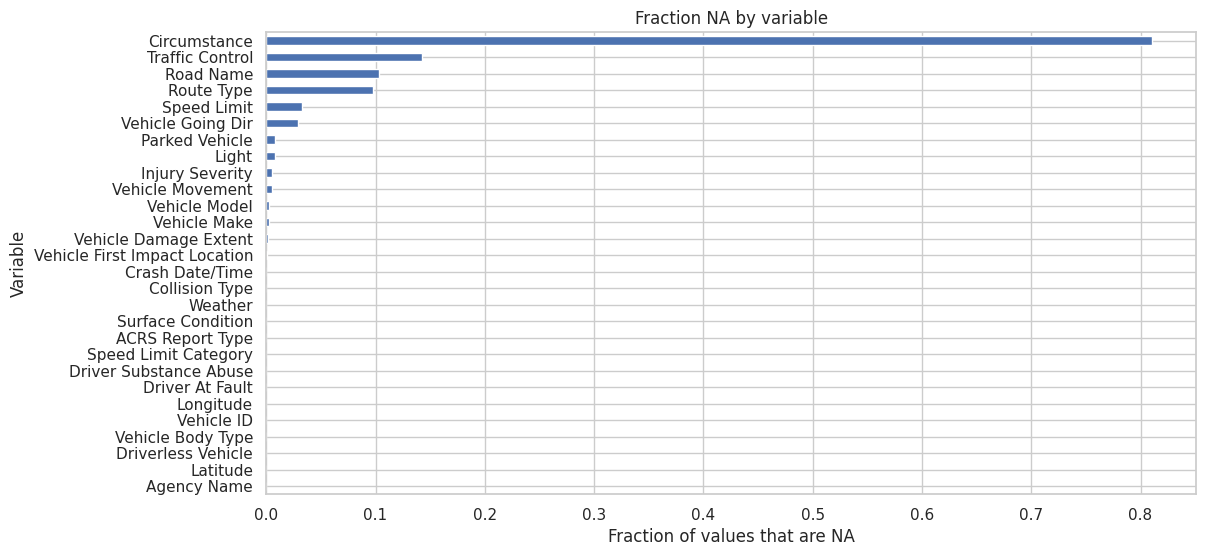

In [ ]:
df.isna().mean().sort_values().plot.barh(figsize=(12, 6))
plt.title('Fraction NA by variable')
plt.xlabel('Fraction of values that are NA')
plt.ylabel('Variable');

While this column does have a lot of missing values, it provides useful information for the analysis we're conducting.

In [ ]:
df['Circumstance'].value_counts(dropna=False)[:5]

,count
Circumstance,
NaN,153011
"RAIN, SNOW, WET",12172
"N/A, WET",9085
"N/A, RAIN, SNOW",1177
"SLEET, HAIL, FREEZ. RAIN, WET",1065


Let's take a look at some of the crashes reported over the years.

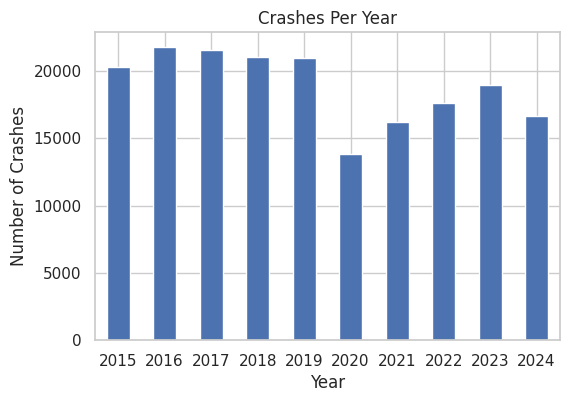

In [ ]:
df['Crash Date/Time'] = pd.to_datetime(df['Crash Date/Time'], format='%m/%d/%Y %I:%M:%S %p')
df['Year'] = df['Crash Date/Time'].dt.year
crashes_per_year = df['Year'].value_counts().sort_index()

crashes_per_year.plot(kind='bar', title='Crashes Per Year', rot=0)
plt.xlabel('Year')
plt.ylabel('Number of Crashes')
plt.show()

 It's interesting to see this data visualized. We can see that there was a sudden drop in the number of crashes from 2019 to 2020. We believe that this has some correlation with the COVID-19 pandemic, when a lot of individuals were staying at home, and working remotely. Thus, there were less people on the road and less accidents altogether.

Let's take a look at weather conditions. We can see that a significant amount of crashes happen in clear weather. An explanation for this could simply be that Montgomery County has a lot of clear days, compared to anything else.

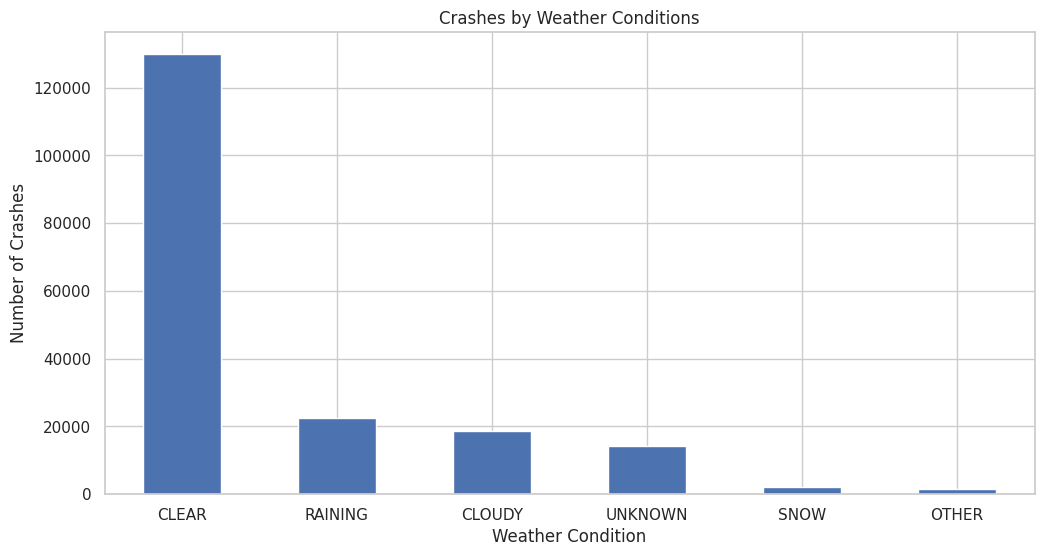

In [ ]:
weather_counts = df['Weather'].value_counts()

weather_counts.plot(kind='bar', title='Crashes by Weather Conditions', figsize=(12, 6))
plt.xlabel('Weather Condition')
plt.ylabel('Number of Crashes')
plt.xticks(rotation=0)
plt.show()


Are there trends over the years, particularly relating to weather conditions?

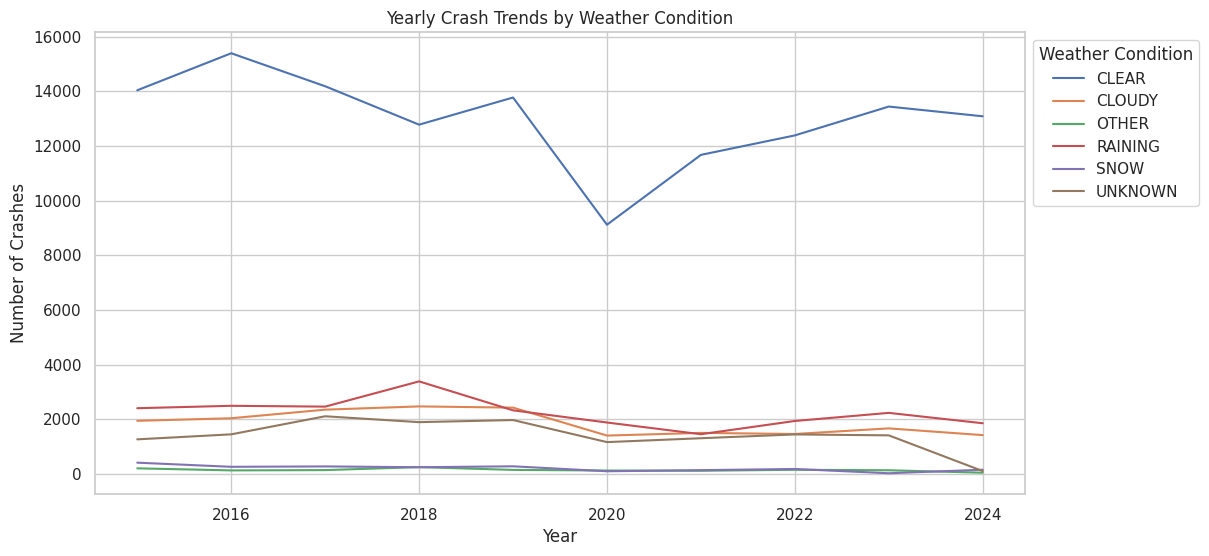

In [ ]:
weather_yearly = df.groupby(['Year', 'Weather']).size().unstack()

weather_yearly.plot(figsize=(12, 6), title='Yearly Crash Trends by Weather Condition')
plt.xlabel('Year')
plt.ylabel('Number of Crashes')
plt.legend(title='Weather Condition', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()


There's a spike in the number of crashes in the rain in 2018. This could be related to a particularly strong rainy season for Montgomery County, Maryland that year. Additionally, there was an increase in clear weather crashes approaching 2024. This could be related to an increase of clear days over the years.

Taking a look at the injury severity by weather condition, we can see some interesting patterns.

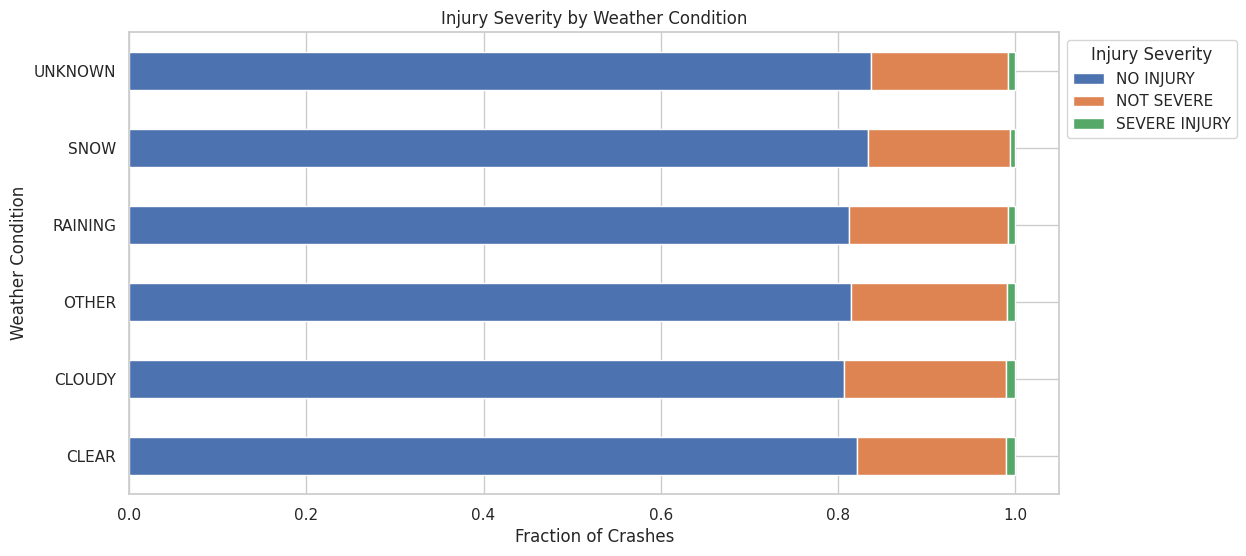

In [ ]:
weather_severity_crosstab = pd.crosstab(df['Weather'], df['Injury Severity'], normalize = 'index')
weather_severity_crosstab.plot(kind='barh', stacked=True, figsize=(12,6))
plt.title('Injury Severity by Weather Condition')
plt.legend(title='Injury Severity', bbox_to_anchor=(1, 1), loc='upper left')
plt.ylabel('Weather Condition')
plt.xlabel('Fraction of Crashes')
plt.show()

Raining and cloudy weather conditions result in less severe injury than clear. A possible answer to this is that people might choose to stay at home more during those weather conditions. Additionally, people might drive more cautiously in raining and cloudy weather conditions, compared to clear.

What type of collision types do we see in different weather conditions?

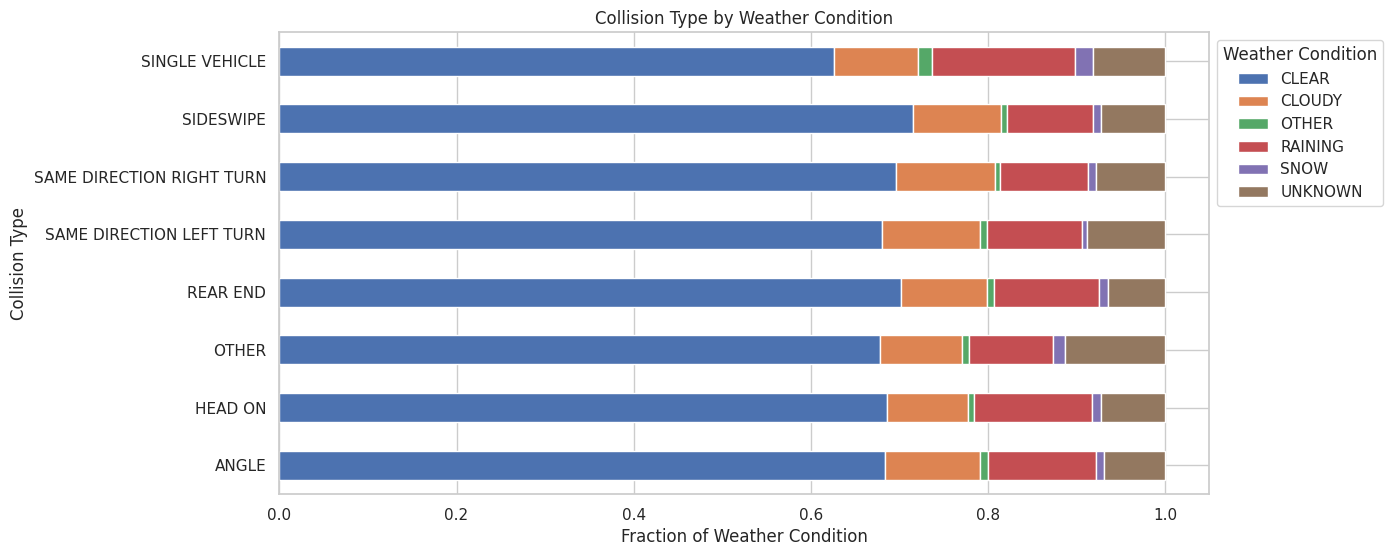

In [ ]:
weather_collision_crosstab = pd.crosstab(df['Collision Type'], df['Weather'], normalize = 'index')
weather_collision_crosstab.plot(kind='barh', stacked=True, figsize=(12,6))
plt.title('Collision Type by Weather Condition')
plt.legend(title='Weather Condition', bbox_to_anchor=(1, 1), loc='upper left')
plt.ylabel('Collision Type')
plt.xlabel('Fraction of Weather Condition')
plt.show()

In this plot, we see a lot of single vehicle collisions happen when there's rain. Interestingly, sideswipes seem to be most common during clear weather. With the exception of clear weather, it seems that head-on collisions are most common in the rain.

How do road surface conditions relate to injury severity?

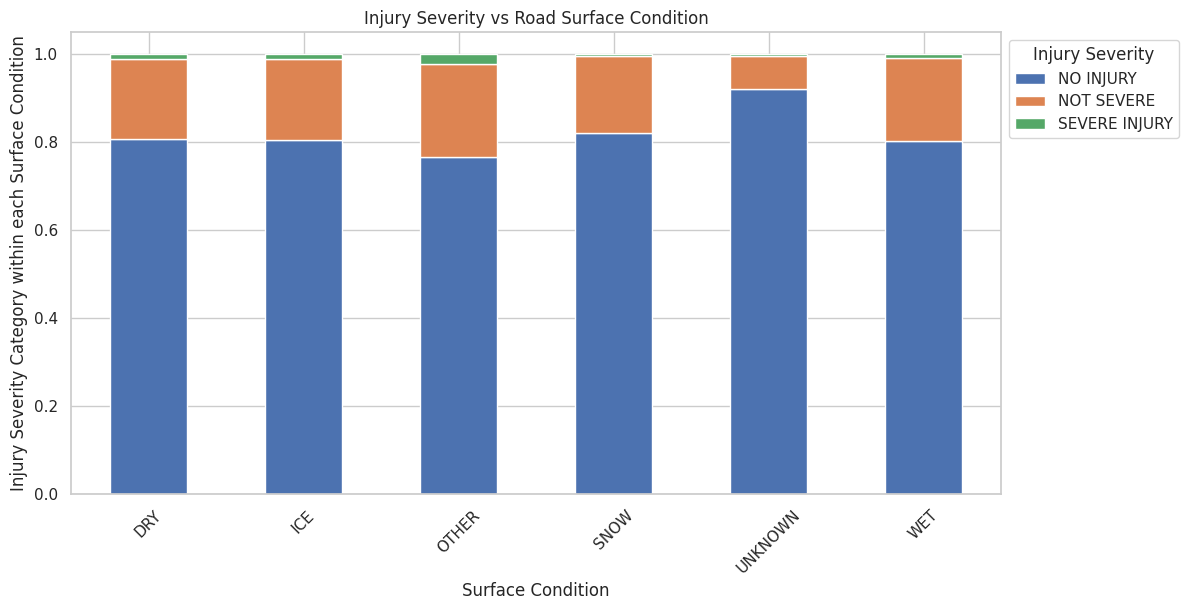

In [ ]:
surface_severity_crosstab = pd.crosstab(df['Surface Condition'], df['Injury Severity'], normalize='index')
surface_severity_crosstab.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.ylabel("Injury Severity Category within each Surface Condition")
plt.title("Injury Severity vs Road Surface Condition")
plt.xlabel('Surface Condition')
plt.xticks(rotation=45)
plt.legend(title='Injury Severity', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()


Interestingly, snow surface condition appears to have one of the lowest fractions of severe accidents. Perhaps driver's in Montgomery County take extra precautions when the surface conditions aren't dry.

Does the day of the week play a role in injury severity?

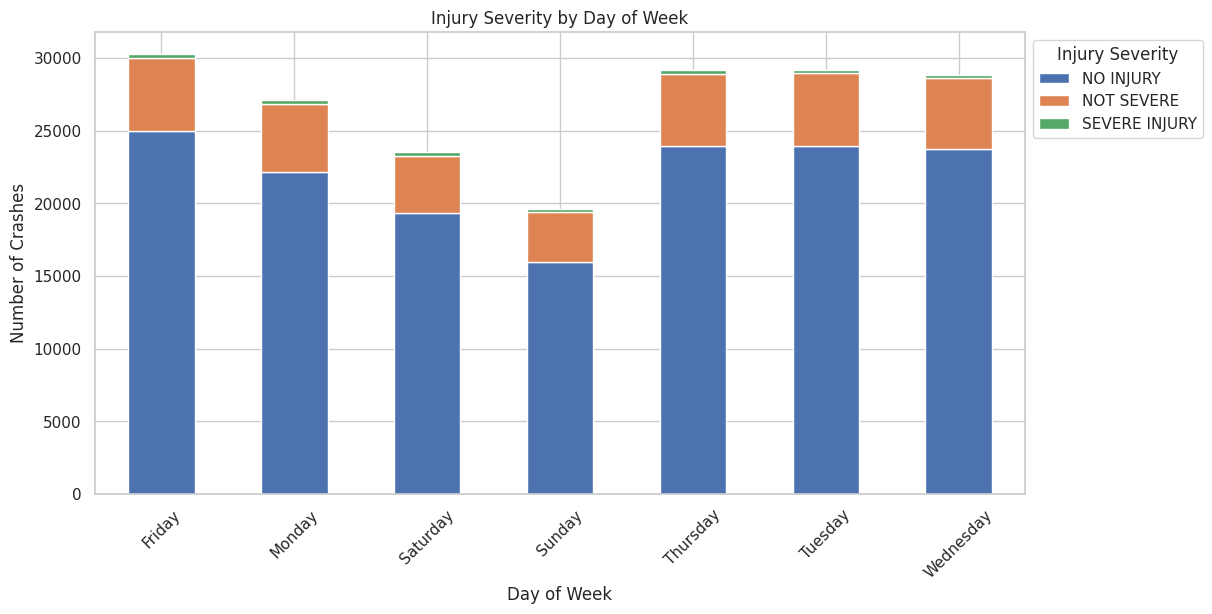

In [ ]:
df['Day_of_Week'] = pd.to_datetime(df['Crash Date/Time']).dt.day_name()
severity_day_crosstab = pd.crosstab(df['Day_of_Week'], df['Injury Severity'])
severity_day_crosstab .plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Injury Severity by Day of Week')
plt.xlabel('Day of Week')
plt.xticks(rotation=45)
plt.ylabel('Number of Crashes')
plt.legend(title='Injury Severity', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

The weekend appears to be the safest days to operate a vehicle, with the number of accidents less than any other day. Sunday having injury severity being less in almost every category. This could be because less people work on the weekends, possibly leading to less people on the roads.


How does driver substance abuse affect severity?

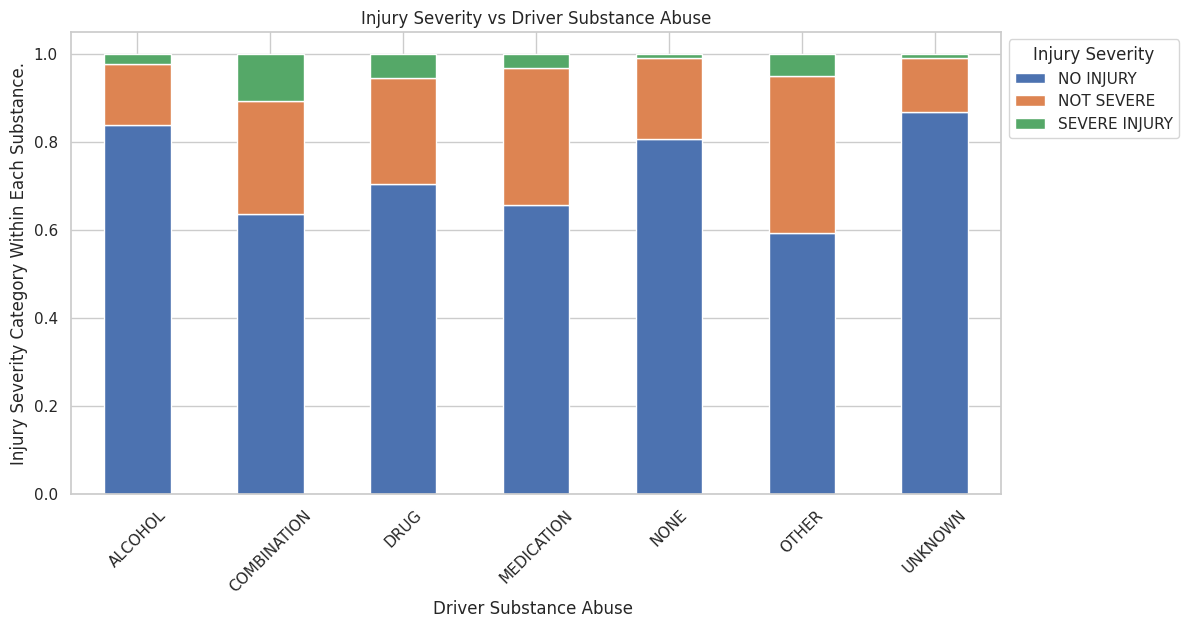

In [ ]:
substance_severity_crosstab = pd.crosstab(df['Driver Substance Abuse'], df['Injury Severity'], normalize='index')
substance_severity_crosstab.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.ylabel("Injury Severity Category Within Each Substance.")
plt.title("Injury Severity vs Driver Substance Abuse")
plt.xlabel('Driver Substance Abuse ')
plt.xticks(rotation=45)
plt.legend(title='Injury Severity', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

An interesting find is that driver's with alcohol in their system have one of the largest fractions of no injury in crashes. This could be linked to studies showing that drivers under the influence of alcohol tend to be less tense during impact, reducing their chances of injury. Moreover, individuals with combined substances in their system have the highest severe injury ratios across all categories.

How does vehicle type affect severity?

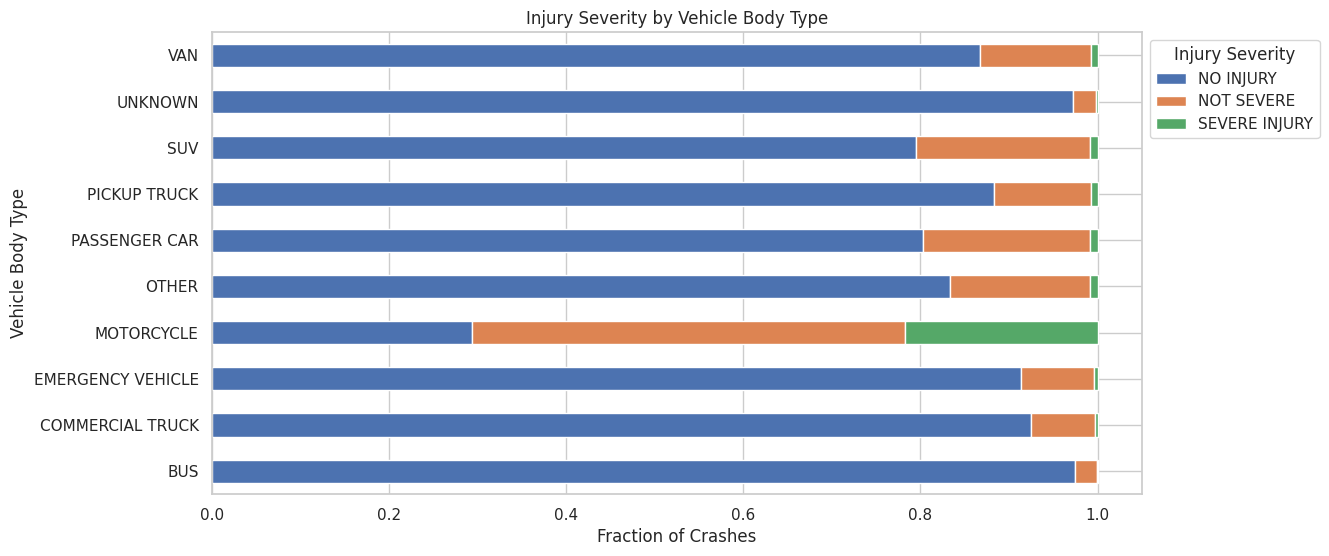

In [ ]:
vehicle_body_severity_crosstab = pd.crosstab(df['Vehicle Body Type'], df['Injury Severity'], normalize = 'index')
vehicle_body_severity_crosstab.plot(kind='barh', stacked=True, figsize=(12, 6))
plt.title('Injury Severity by Vehicle Body Type')
plt.xlabel('Fraction of Crashes')
plt.ylabel('Vehicle Body Type')
plt.legend(title='Injury Severity', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

 In this plot, we explore the severity of injuries in regard to vehicle type. It's fairly clear that motorcycles account for the highest injury severity in every category except no apparent injury. This is undoubtedly due to the lack of safety features equipped on motorcycles. Not surprising, larger vehicles like pickup trucks, commercial trucks, and buses are much safer in terms of injury severity.

Does the speed limit play a role in injury severity?

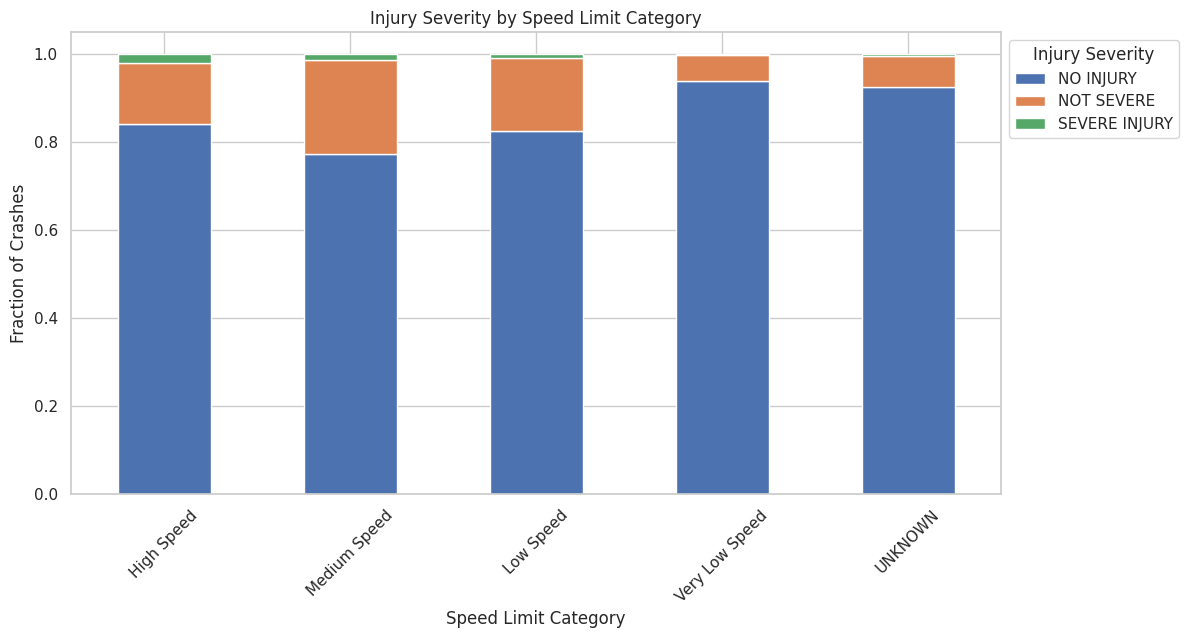

In [ ]:
custom_order = ['High Speed', 'Medium Speed', 'Low Speed', 'Very Low Speed', 'UNKNOWN']

df['Speed Limit Category'] = pd.Categorical(
    df['Speed Limit Category'],
    categories=custom_order,
    ordered=True
)

speed_severity_crosstab = pd.crosstab(df['Speed Limit Category'], df['Injury Severity'], normalize = 'index')
speed_severity_crosstab.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Injury Severity by Speed Limit Category')
plt.xlabel('Speed Limit Category')
plt.xticks(rotation=45)
plt.ylabel('Fraction of Crashes')
plt.legend(title='Injury Severity', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

Looking at our data, if there is a crash at higher speed limits there's an increased likelihood of injury. There’s a variety of reasons that can contribute to this trend. Perhaps the lower speed crashes happen in towns, or parking lots. Whereas medium and high speeds can occur in backroads and freeways.

## Machine Learning

### Data preparation for machine learning

In order to get into our machine learning algorithm we will now convert our current predictor variables into dummy variables and drop all NA values.

In [ ]:
df.dropna(inplace = True)

In [ ]:
df = pd.get_dummies(df, columns=['Weather'], drop_first=False)
df = pd.get_dummies(df, columns=['Surface Condition'], drop_first=False)
df = pd.get_dummies(df, columns=['Vehicle Body Type'], drop_first= False)
df = pd.get_dummies(df, columns=['Speed Limit Category'], drop_first=False)
df = pd.get_dummies(df, columns=['Light'], drop_first=False)
df = pd.get_dummies(df, columns = ['Traffic Control'], drop_first = False)
df = pd.get_dummies(df, columns = ['Vehicle Movement'], drop_first = False)
df = pd.get_dummies(df, columns = ['Vehicle Model'] , drop_first = False)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28001 entries, 16 to 188793
Columns: 2274 entries, Agency Name to Vehicle Model_ZDX
dtypes: bool(2252), datetime64[ns](1), float64(2), int32(1), object(18)
memory usage: 64.9+ MB


We will now assign our target and predictor variables.

In [ ]:
target = 'Injury Severity'
predictors = ['Weather_CLOUDY', 'Weather_CLEAR', 'Weather_RAINING', "Weather_SNOW",
              'Surface Condition_DRY','Surface Condition_ICE', 'Surface Condition_OTHER',
              'Surface Condition_SNOW', 'Surface Condition_WET', 'Vehicle Body Type_BUS',
              'Vehicle Body Type_COMMERCIAL TRUCK', 'Vehicle Body Type_EMERGENCY VEHICLE',
              'Vehicle Body Type_MOTORCYCLE', 'Vehicle Body Type_OTHER',
              'Vehicle Body Type_PASSENGER CAR', 'Vehicle Body Type_PICKUP TRUCK',
              'Vehicle Body Type_SUV', 'Vehicle Body Type_VAN', 'Speed Limit Category_High Speed',
              'Speed Limit Category_Medium Speed', 'Speed Limit Category_Low Speed',
              'Speed Limit Category_Very Low Speed', 'Speed Limit Category_UNKNOWN', 'Light_DARK',
              'Light_DAYLIGHT', 'Light_UNKNOWN', 'Traffic Control_CONTROLS', 'Traffic Control_NO CONTROLS', 'Traffic Control_OTHER',
              'Vehicle Movement_ACCELERATING','Vehicle Movement_BACKING', 'Vehicle Movement_CHANGING LANES',
              'Vehicle Movement_MAKING U-TURN', 'Vehicle Movement_MOVING CONSTANT SPEED',
              'Vehicle Movement_STARTING FROM LANE',
              'Vehicle Movement_TURNING LEFT', 'Vehicle Movement_TURNING RIGHT','Vehicle Movement_UNKNOWN']

X = df[predictors].values
y = df[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

Performing a sanity check on our training data.

In [ ]:
print(X_train.shape)
print(y_train.shape)

(19600, 38)
(19600,)


# Compute baseline accuracy

In [ ]:
majority = pd.Series(y_train).value_counts().index[0]
accuracy_baseline = (majority == y_train).mean()
print(f"Baseline accuracy: {accuracy_baseline:.3f}")

Baseline accuracy: 0.801


# Building a classification tree

In [ ]:
clf = DecisionTreeClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [ ]:
def plot_tree_custom(clf, feature_names, class_names):
    dot_data = export_graphviz(clf, precision=2,
                         feature_names=feature_names,
                         proportion=True,
                         class_names=class_names,
                         filled=True, rounded=True,
                         special_characters=True)

    graph = graphviz.Source(dot_data)
    return graph

In [ ]:
def plot_tree_custom_basic(clf, feature_names, class_names, max_depth=3):
    fig, ax = plt.subplots(figsize=(20, 10), dpi=150)
    plot_tree(
        clf,
        feature_names=feature_names,
        class_names=class_names,
        filled=True,
        rounded=True,
        proportion=True,
        fontsize=10,
        max_depth=max_depth,
        ax=ax,
    )
    plt.show()

# Making predictions and assessing our MLM

With our current predictor variables and target, we notice our accuracy goes up by 0.005.

In [ ]:
accuracy = clf.score(X_train, y_train)
print(f"Cross-validation accuracy:{accuracy:.3f}")

Cross-validation accuracy:0.806


Let's plot our learning curve to try to gain some insight.

In [ ]:
def plot_learning_curve(clf, X_train, y_train):
    train_sizes, train_scores, test_scores = \
    learning_curve(clf, X_train, y_train, cv=10, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.plot(train_sizes, train_scores_mean, label='train')
    plt.plot(train_sizes, test_scores_mean, label='test')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.title('Learning curve, classification tree')
    plt.legend();

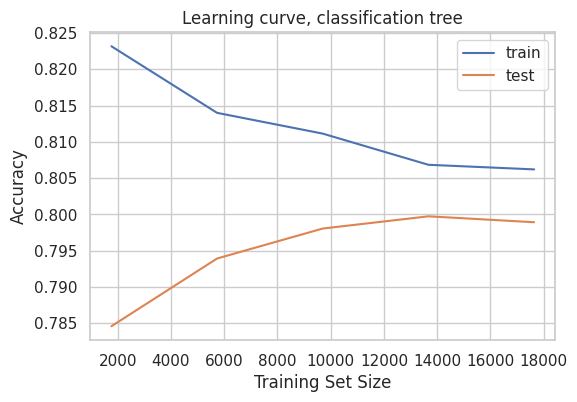

In [ ]:
plot_learning_curve(clf, X_train, y_train)

This plot is displaying a high variance scenario.

# Hyperparameter tuning

Now we will adjust the parameters 'min_samples_leaf' and 'max_depth' in order to increase our accuracy.

In [ ]:
grid = {'max_depth': range(2,10,1),
               'min_samples_leaf':[10, 15, 20, 25, 30],
               'max_features': ['sqrt', None]}
tree_cv = GridSearchCV(clf, grid, cv=10)
tree_cv.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=DecisionTreeClassifier(max_depth=10, random_state=0),
             param_grid={'max_depth': range(2, 10),
                         'max_features': ['sqrt', None],
                         'min_samples_leaf': [10, 15, 20, 25, 30]})

Looking at our grid search we can conclude that our tree works well with depth of 2 and a minimum of 25 training examples.

In [ ]:
print(tree_cv.best_params_)

{'max_depth': 2, 'max_features': None, 'min_samples_leaf': 10}


Our best cross-validation accuracy is a decrease of about 0.003 from our un-tuned tree.

In [ ]:
best_accuracy = tree_cv.best_score_
print(f"Best cross-validation accuracy: {best_accuracy:.3f}")

Best cross-validation accuracy: 0.803


Our learning curve for our tuned tree.

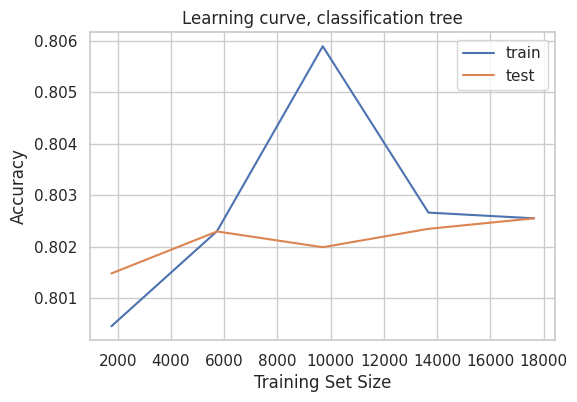

In [ ]:
plot_learning_curve(tree_cv.best_estimator_, X_train, y_train)

Our learning curve has many sharp points and an overall strange appearance. Our training accuracy actually starts by decreasing and then peaking at a mid-size training set, then decreasing and re-increasing again until meeting with our test data. Our test data is actually fairly moderate with slow and small improvements until it appears to be flat-lining.

It is valuable to note that our cross-validation went down as we performed hyper-tuning but was still higher than our baseline. Our error must be within the tuning we commited.

It also seems that our data comes to its peak at the largest training set size, potentially signaling that we need to train on more data to really see the potential for our MLM.

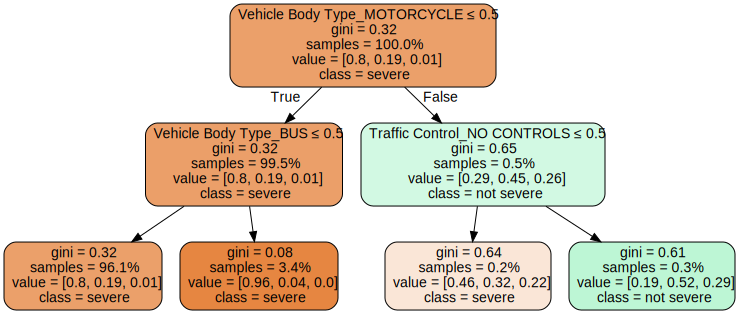

In [ ]:
plot_tree_custom(tree_cv.best_estimator_, feature_names=predictors, class_names=['severe', 'not severe', 'no injury'])

# Feature importance using tree classifier

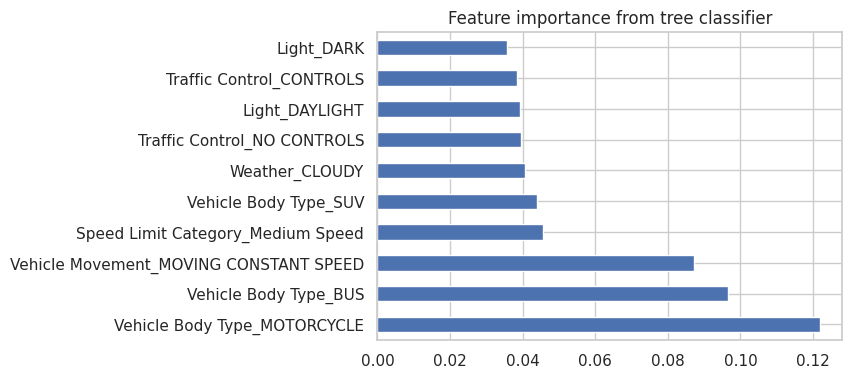

In [ ]:
importance = pd.Series(clf.feature_importances_, index=predictors)
importance.sort_values(ascending = False)[:10].plot.barh()
plt.title('Feature importance from tree classifier')
plt.show();

Looking at this graph we can see the most important feature in our values in the motorcyle vehicle body type.

# Feature importance using forward feature selection

In [ ]:
def forward_selection_classif(clf, X, y, threshold=None, num_folds=5):
    remaining = list(range(X.shape[1]))
    selected = []
    accuracies = []
    previous_best = 0.0
    while len(remaining) > 0:

        best_accuracy = 0.0

        best_feature = None

        for feature in remaining:

            temp_selected = selected + [feature]

            scores = cross_val_score(clf, X[:, temp_selected], y, cv=num_folds)

            accuracy = scores.mean()
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_feature = feature

        if threshold is not None and (best_accuracy - previous_best) < threshold:
            break


        if best_feature is not None:
            selected.append(best_feature)
            remaining.remove(best_feature)
            accuracies.append(best_accuracy)
            previous_best = best_accuracy

    return selected, accuracies

In [ ]:
def plot_selected(selected, accuracies, predictors):
    pd.Series(accuracies, index=predictors[selected]).plot.barh()
    plt.xlim(0.5, 1.0)
    plt.xlabel('Cross-validation accuracy')
    plt.title('Result of forward feature selection')

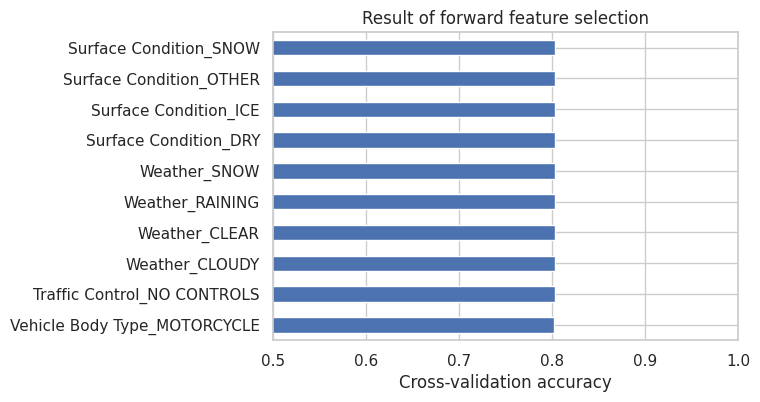

In [ ]:
selected, accuracies = forward_selection_classif(tree_cv.best_estimator_, X_train, y_train, num_folds=10)
plot_selected(selected[:10], accuracies[:10], np.array(predictors))

Our accuracy values are all the same range.

In [ ]:
print(np.array(accuracies[:10]).round(4))

[0.8023 0.8026 0.8026 0.8026 0.8026 0.8026 0.8026 0.8026 0.8026 0.8026]


In [ ]:
test_accuracy = tree_cv.score(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.796


### Conclusion

To conclude our machine learning, we have observed some strange behavior that we can link back to some issues with our implementation of the data. It would be worthy to attempt this data set again with a different approach. For example we could narrow our target values to two and use more training data and predictor variables. For our current run we see we lacked in the usage of all our training data and that caused a slimmer increase in accuracy. We could also explore another classification MLA such as logistic regression. Overall, our test accuracy is lower than our baseline and we had some issues with bias and data usage.